In [94]:
## Develop VAE for kinase resistance predtictions

import numpy as np
import scipy as sp
import os, sys
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


# a class to hold kinase information
class kinase:
    def __init__(self, acc, gene):
        self.acc = acc
        self.gene = gene
        self.fasta = ''
        self.domains = {}
        self.hmmsearch = []


In [95]:
kinases = {}
def loadFasta():
    for line in open('humanKinases.fasta', 'r'):
        #print (line)
        if line[0] == '>':
            acc = line.split('|')[1].replace('\n', '')
            gene = line.split('GN=')[1].split()[0]
            kinases[acc] = kinase(acc, gene)
        else:
            kinases[acc].fasta += line.replace('\n', '')
            

In [96]:
loadFasta()
print (kinases['P00533'].fasta)

MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRA

In [97]:
def hmmsearch():
    '''
    Function to do an hmmsearch of all kinases against Pkinase.hmm
    and store the mappings. Note that some kinases may have more than
    one Pkinase domain.
    '''
    #os.system('hmmsearch -o out.txt ../pfam/Pkinase.hmm humanKinases.fasta')
    flag = 0
    for line in open('out.txt', 'r'):
        if line[:2] == '>>':
            acc = line.split('|')[1]
            flag = 1
            #print (acc)
        if flag == 1 and line.split()!= []:
            if '== domain' in line:
                domainNum = line.split('domain')[1].split()[0]
                kinases[acc].domains[domainNum] = {}
            elif line.split()[0] == 'Pkinase':
                hmmStart = int(line.split()[1])
                hmmSeq = line.split()[2]
                hmmEnd = int(line.split()[3])
            elif acc in line.split()[0]:
                kinaseStart = int(line.split()[1])
                kinaseSeq = line.split()[2]
                kinaseEnd = int(line.split()[3])
                for hmmChar, kinaseChar in zip(hmmSeq, kinaseSeq):
                    if hmmChar not in ['.', '-'] and kinaseChar not in ['.', '-']:
                        #kinases[acc].domains[domainNum][kinaseStart] = hmmStart
                        kinases[acc].domains[domainNum][hmmStart] = kinaseStart
                        hmmStart += 1
                        kinaseStart += 1
                    elif hmmChar in ['.', '-']:
                        kinaseStart += 1
                    elif kinaseChar in ['.', '-']:
                        hmmStart += 1
        #print (kinases[acc].domains)
        #sys.exit()
    #print (kinases['Q9BUB5'].domains)
hmmsearch()

[254, 248, 89, 155, 256, 256, 251, 251, 253, 254, 255, 256, 253, 256, 256, 256, 250, 237, 248, 258, 250, 246, 250, 256, 254, 20, 22, 255, 250, 248, 255, 253, 256, 254, 250, 243, 251, 231, 244, 244, 129, 130, 251, 251, 255, 244, 249, 249, 253, 132, 125, 251, 249, 244, 203, 251, 249, 249, 242, 127, 247, 247, 252, 73, 173, 236, 243, 242, 244, 240, 254, 256, 241, 249, 243, 248, 254, 247, 245, 250, 241, 255, 94, 245, 254, 235, 250, 255, 249, 249, 258, 248, 247, 236, 252, 254, 235, 249, 254, 248, 251, 256, 253, 255, 252, 235, 246, 255, 246, 255, 245, 238, 192, 249, 235, 250, 248, 242, 249, 252, 227, 244, 248, 252, 29, 144, 89, 49, 255, 245, 248, 240, 249, 248, 241, 91, 155, 241, 245, 243, 244, 245, 237, 244, 238, 250, 254, 254, 244, 251, 253, 251, 250, 250, 250, 237, 244, 237, 238, 253, 245, 251, 251, 253, 251, 251, 250, 248, 250, 239, 251, 250, 242, 249, 252, 101, 251, 253, 253, 251, 251, 235, 242, 238, 240, 251, 249, 236, 241, 242, 244, 243, 235, 245, 245, 240, 239, 74, 157, 247, 255, 130,

<AxesSubplot:xlabel='Length', ylabel='Count'>

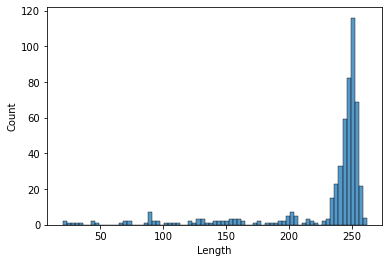

In [98]:
data = []
for acc in kinases:
    #print (kinases[acc].domains)
    for domainNum in kinases[acc].domains:
        #print (domainNum)
        data.append(len(kinases[acc].domains[domainNum]))

print (data)
df = pd.DataFrame(data = data, columns=['Length'])
sns.histplot(data=df, x="Length")

In [100]:
def oneHotEncoding(acc):
    AA = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']
    #print (len(AA))
    trainData = []
    for acc in kinases:
        for domainNum in kinases[acc].domains:
            if len(kinases[acc].domains[domainNum]) >= 235:
                data = []
                numZeros = 0
                for i in range(1,265):
                    if i in kinases[acc].domains[domainNum]:
                        position = kinases[acc].domains[domainNum][i]
                        residue = kinases[acc].fasta[position-1]
                    else:
                        residue = '-'

                    row = []
                    for aa in AA:
                        if residue == aa:
                            row.append(1)
                        else:
                            row.append(0)
                    data.append(row)
                data = np.array(data)
                if data.shape == (264,len(AA)):
                    #print (data.shape)
                    trainData.append(data)
    trainData = np.array(trainData)
    print (np.stack(trainData, axis=0).shape)
    return (trainData)

trainData = oneHotEncoding(acc)
print (trainData.shape)

(419, 264, 21)
(419, 264, 21)


In [101]:
## Create Sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Built encoder
latent_dim = 2

encoder_inputs = keras.Input(shape=(264, 21, 1))
x = layers.Conv2D(20, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(50, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


## Built decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(66 * 6 * 50, activation="relu")(latent_inputs)
x = layers.Reshape((66, 6, 50))(x)
x = layers.Conv2DTranspose(50, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(20, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Cropping2D(cropping=((0, 0), (2, 1)))(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(decoder_outputs)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_101 (InputLayer)          [(None, 264, 21, 1)] 0                                            
______________________________________________________________________________________

In [ ]:
## Define VAE
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

print (trainData.shape)
trainData = trainData.reshape(419, 264, 21, 1)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(trainData, epochs=50, batch_size=100)

(419, 264, 21)
Epoch 1/50
5/5 [==============================] - 6s 987ms/step - loss: 3804.0889 - reconstruction_loss: 3774.4458 - kl_loss: 1.0806
Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 3344.1039 - reconstruction_loss: 2844.0220 - kl_loss: 291.8949
Epoch 3/50
5/5 [==============================] - 5s 934ms/step - loss: 2332.3761 - reconstruction_loss: 1964.3425 - kl_loss: 196.4137
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 1595.9043 - reconstruction_loss: 1396.9181 - kl_loss: 117.9119
Epoch 5/50


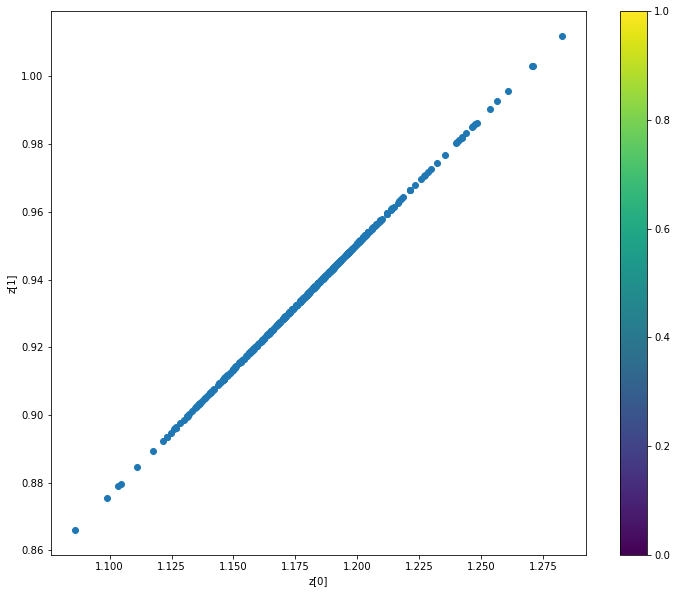

In [93]:
def plot_label_clusters(vae, data, labels=None):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


#(x_train, y_train), _ = keras.datasets.mnist.load_data()
#x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, trainData)
